In [364]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn import metrics
import seaborn as sns
from train_test_divide import extract_normal, extract_spammers_scrapers
import numpy as np
import os
import matplotlib.pyplot as plt

In [83]:
#Function for labelling data
def label_data(dataframe):
    labels = []
    for i in range (0, dataframe.shape[0]):
        instance = dataframe.iloc[i]
        if (instance['user'] == 'user-1003' or instance['user'] == 'user-1004' or instance['user'] == 'user-1005'):
            labels.append(-1)
        else:
            labels.append(1)
    dataframe['label'] = labels
    return dataframe

In [367]:
path = os.path.dirname(os.path.abspath("__file__"))
dir = path.replace('notebooks', 'csv_files')
os.chdir(dir)

df_anomaly_train = pd.read_csv('train.csv')
df_anomaly_test = pd.read_csv('test.csv')

anomaly_inputs = ['request_freq', 'avg_tokens', 'longest_consec', 'var_score', 'sequence_time']
#anomaly_inputs = ['var_score', 'longest_consec']

In [366]:
model_if = IsolationForest(contamination=0.002, random_state=42)
model_if.fit(df_anomaly_train[anomaly_inputs])

c:\Users\vhage\Documents\Skolarbete\Exjobb\request-analyzer-model\venv\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.002, random_state=42)

In [368]:
#Code for checking how many spammers and scarpers that are present in test dataset
df_test = pd.read_csv('test.csv')
df_test_spam = extract_spammers_scrapers(df_test)
df_test_spam

,request_freq,avg_tokens,longest_consec,var_score,sequence_time,user
0,0.867778,1.0,7.0,0.000078,7.810,user-1003
1,1.758222,1.0,4.0,0.000055,15.824,user-1003
2,3.010556,1.0,4.0,0.000050,27.095,user-1003
3,1.561889,1.0,6.0,0.000055,14.057,user-1003
4,1.896667,1.0,6.0,0.000065,17.070,user-1003
...,...,...,...,...,...,...
13372,3.063000,1.0,4.0,0.000039,24.504,user-1004
13373,0.520000,1.0,9.0,0.000077,4.160,user-1004
13374,1.581250,1.0,6.0,0.000051,12.650,user-1004
13375,2.155500,1.0,3.0,0.000033,17.244,user-1004


In [369]:
#Code for checking how many normal users that are present in test dataset
df_test_normal = extract_normal(df_test, df_test_spam)
df_test_normal

,request_freq,avg_tokens,longest_consec,var_score,sequence_time,user
13377,2.366222,1.000000,2.0,0.000023,21.296,user-65
13378,2174.058667,0.030303,2.0,0.000031,19566.528,user-65
13379,3.009333,1.000000,3.0,0.000023,27.084,user-65
13380,2.015000,1.000000,3.0,0.000024,16.120,user-565
13381,2.343444,1.000000,3.0,0.000032,21.091,user-842
...,...,...,...,...,...,...
16048,2.594000,1.000000,3.0,0.000027,23.346,user-754
16049,2593.905375,0.042857,2.0,0.000018,20751.243,user-754
16050,2.990875,1.000000,3.0,0.000026,23.927,user-641
16051,2310.216125,0.031746,2.0,0.000020,18481.729,user-641


In [370]:
df_anomaly_test['anomaly_score'] = model_if.decision_function(df_anomaly_test[anomaly_inputs])
df_anomaly_test['anomaly'] = model_if.predict(df_anomaly_test[anomaly_inputs])

#This dataframe will only include anomaly score and anomaly label
df_anomaly_score = df_anomaly_test.loc[:,['anomaly_score', 'anomaly']]
df_anomaly_score['user'] = df_anomaly_test['user']
df_a = df_anomaly_score.loc[df_anomaly_score['anomaly']==-1] 
print(df_a)

       anomaly_score  anomaly       user
66         -0.007208       -1  user-1003
122        -0.007208       -1  user-1003
123        -0.007208       -1  user-1003
176        -0.007208       -1  user-1003
203        -0.007208       -1  user-1003
...              ...      ...        ...
15872      -0.020590       -1   user-449
15875      -0.015083       -1   user-970
15892      -0.002221       -1   user-443
15916      -0.016184       -1   user-521
15979      -0.020590       -1   user-378

[2552 rows x 3 columns]


In [371]:
spam = extract_spammers_scrapers(df_a)
print(spam.shape[0])

normal = extract_normal(df_a, spam)
print(normal.shape[0])

2504
48


In [138]:
#To check which users thar are flagged as anomalies
print(set(df_a['user'].to_list()))
#print(df_anomaly_test.loc[df_anomaly_test['user']== ' user-693'])

set()


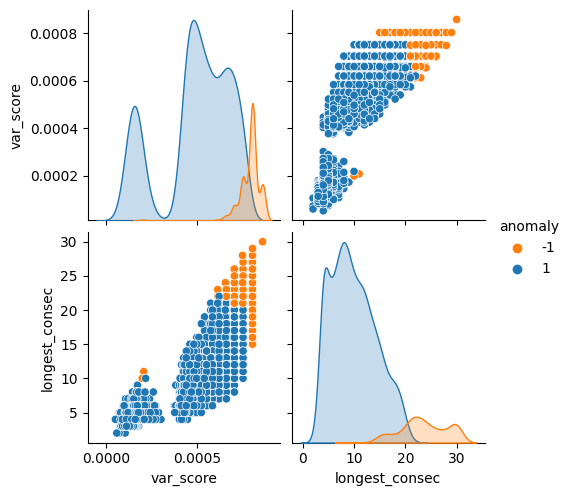

In [123]:
#Plots showcasing the outliers detected by isolation forest
palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(df_anomaly_test, vars=anomaly_inputs, hue='anomaly', palette=palette)

In [390]:
true_labels = label_data(df_anomaly_test)['label']
pred_labels = df_anomaly_score['anomaly']

#cf_matrix = metrics.confusion_matrix(true_labels, pred_labels)

#Values taken from average
cf_matrix = np.array([[1358, 3101],[17, 941]])
cf_matrix

array([[1358, 3101],
       [  17,  941]])

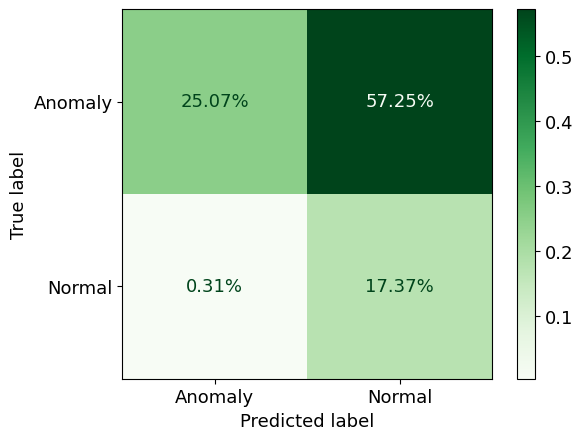

In [391]:
cm_display = metrics.ConfusionMatrixDisplay(cf_matrix/np.sum(cf_matrix), display_labels = ['Anomaly', 'Normal'], )

cm_display.plot(values_format='.2%', cmap='Greens')
plt.rcParams.update({'font.size': 13})
plt.show()